# Accidents.

In [1]:
import re
import os
import pandas as pd
import seaborn as sns
from simpledbf import Dbf5
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

# BaseEstimator adds fit_transform();
# TransformerMixing adds get_params() & set_params()
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

#### The goal of the project is to fit a model that predict whether an accident is caused by a man or a woman.

The first step is to clean the data. Since there are variables that are not of interest for the study or, the lack of information about some values for a given parameter, add no valuable information, we will remove them from the dataset. We will do this using *scikit-learn's pipeline*

In [2]:
class DFSelector(BaseEstimator, TransformerMixin):
    """
    An element of the pipeline. It will be used to
    select the necessary columns to transform some
    categorical variables
    """
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes].values

In [3]:
queries = "SEXO != 1 & ALIENTO != 6 & CINTURON != 9 & EDAD not in (0, 99)"

accidents = Dbf5("data/bdatus15.dbf").to_dataframe()
accidents = accidents.query(queries)
accidents.shape

(118087, 42)

In [4]:
# Splitting into train and test set
acc_train, acc_test = train_test_split(accidents, test_size=0.2, random_state=1643)

----------
## Analyzing the Data

We look at the proportion of men **(2)**, and women **(3)** that caused an accident

In [11]:
acc_train.SEXO.value_counts(normalize=True)

2    0.830124
3    0.169876
Name: SEXO, dtype: float64

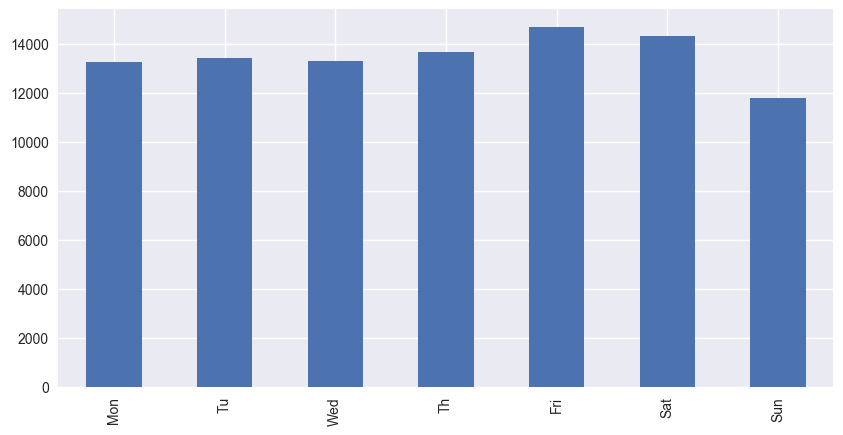

In [6]:
plt.figure(figsize=(10,5), dpi=100)
weekdays = ("Mon", "Tu", "Wed", "Th", "Fri", "Sat", "Sun")
acc_train.DIASEMANA.value_counts(sort=False).plot(kind="bar")
plt.xticks(range(7), weekdays);

In [12]:
acc_train.DIASEMANA.value_counts(normalize=True)

5    0.155522
6    0.151849
4    0.144587
2    0.142205
3    0.140713
1    0.140448
7    0.124676
Name: DIASEMANA, dtype: float64

We now want to know the frequency of the types of accidents. Since the values are messy (we extracted the string of valyes from a PDF), we need to clean them in order to obtain a more representative frquency plot

In [13]:
acc_code = """Clave 1.- Colisión con vehículo automotor
Clave 2.- Colisión con peatón (atropellamiento)
Clave 3.- Colisión con animal
Clave 4.- Colisión con objeto fijo
Clave 5.- Volcadura
Clave 6.- Caída de pasajero
Clave 7.- Salida del camino
Clave 8.- Incendio
Clave 9.- Colisión con ferrocarril
Clave 10.- Colisión con motocicleta
Clave 11.- Colisión con ciclista
Clave 12.- Otro""".split("\n")

re_code = "Clave [1-9][0-9]?.- "
acc_code = [re.sub(re_code, "", acc) for ix, acc in enumerate(acc_code)]
acc_code

['Colisión con vehículo automotor',
 'Colisión con peatón (atropellamiento)',
 'Colisión con animal',
 'Colisión con objeto fijo',
 'Volcadura',
 'Caída de pasajero',
 'Salida del camino',
 'Incendio',
 'Colisión con ferrocarril',
 'Colisión con motocicleta',
 'Colisión con ciclista',
 'Otro']

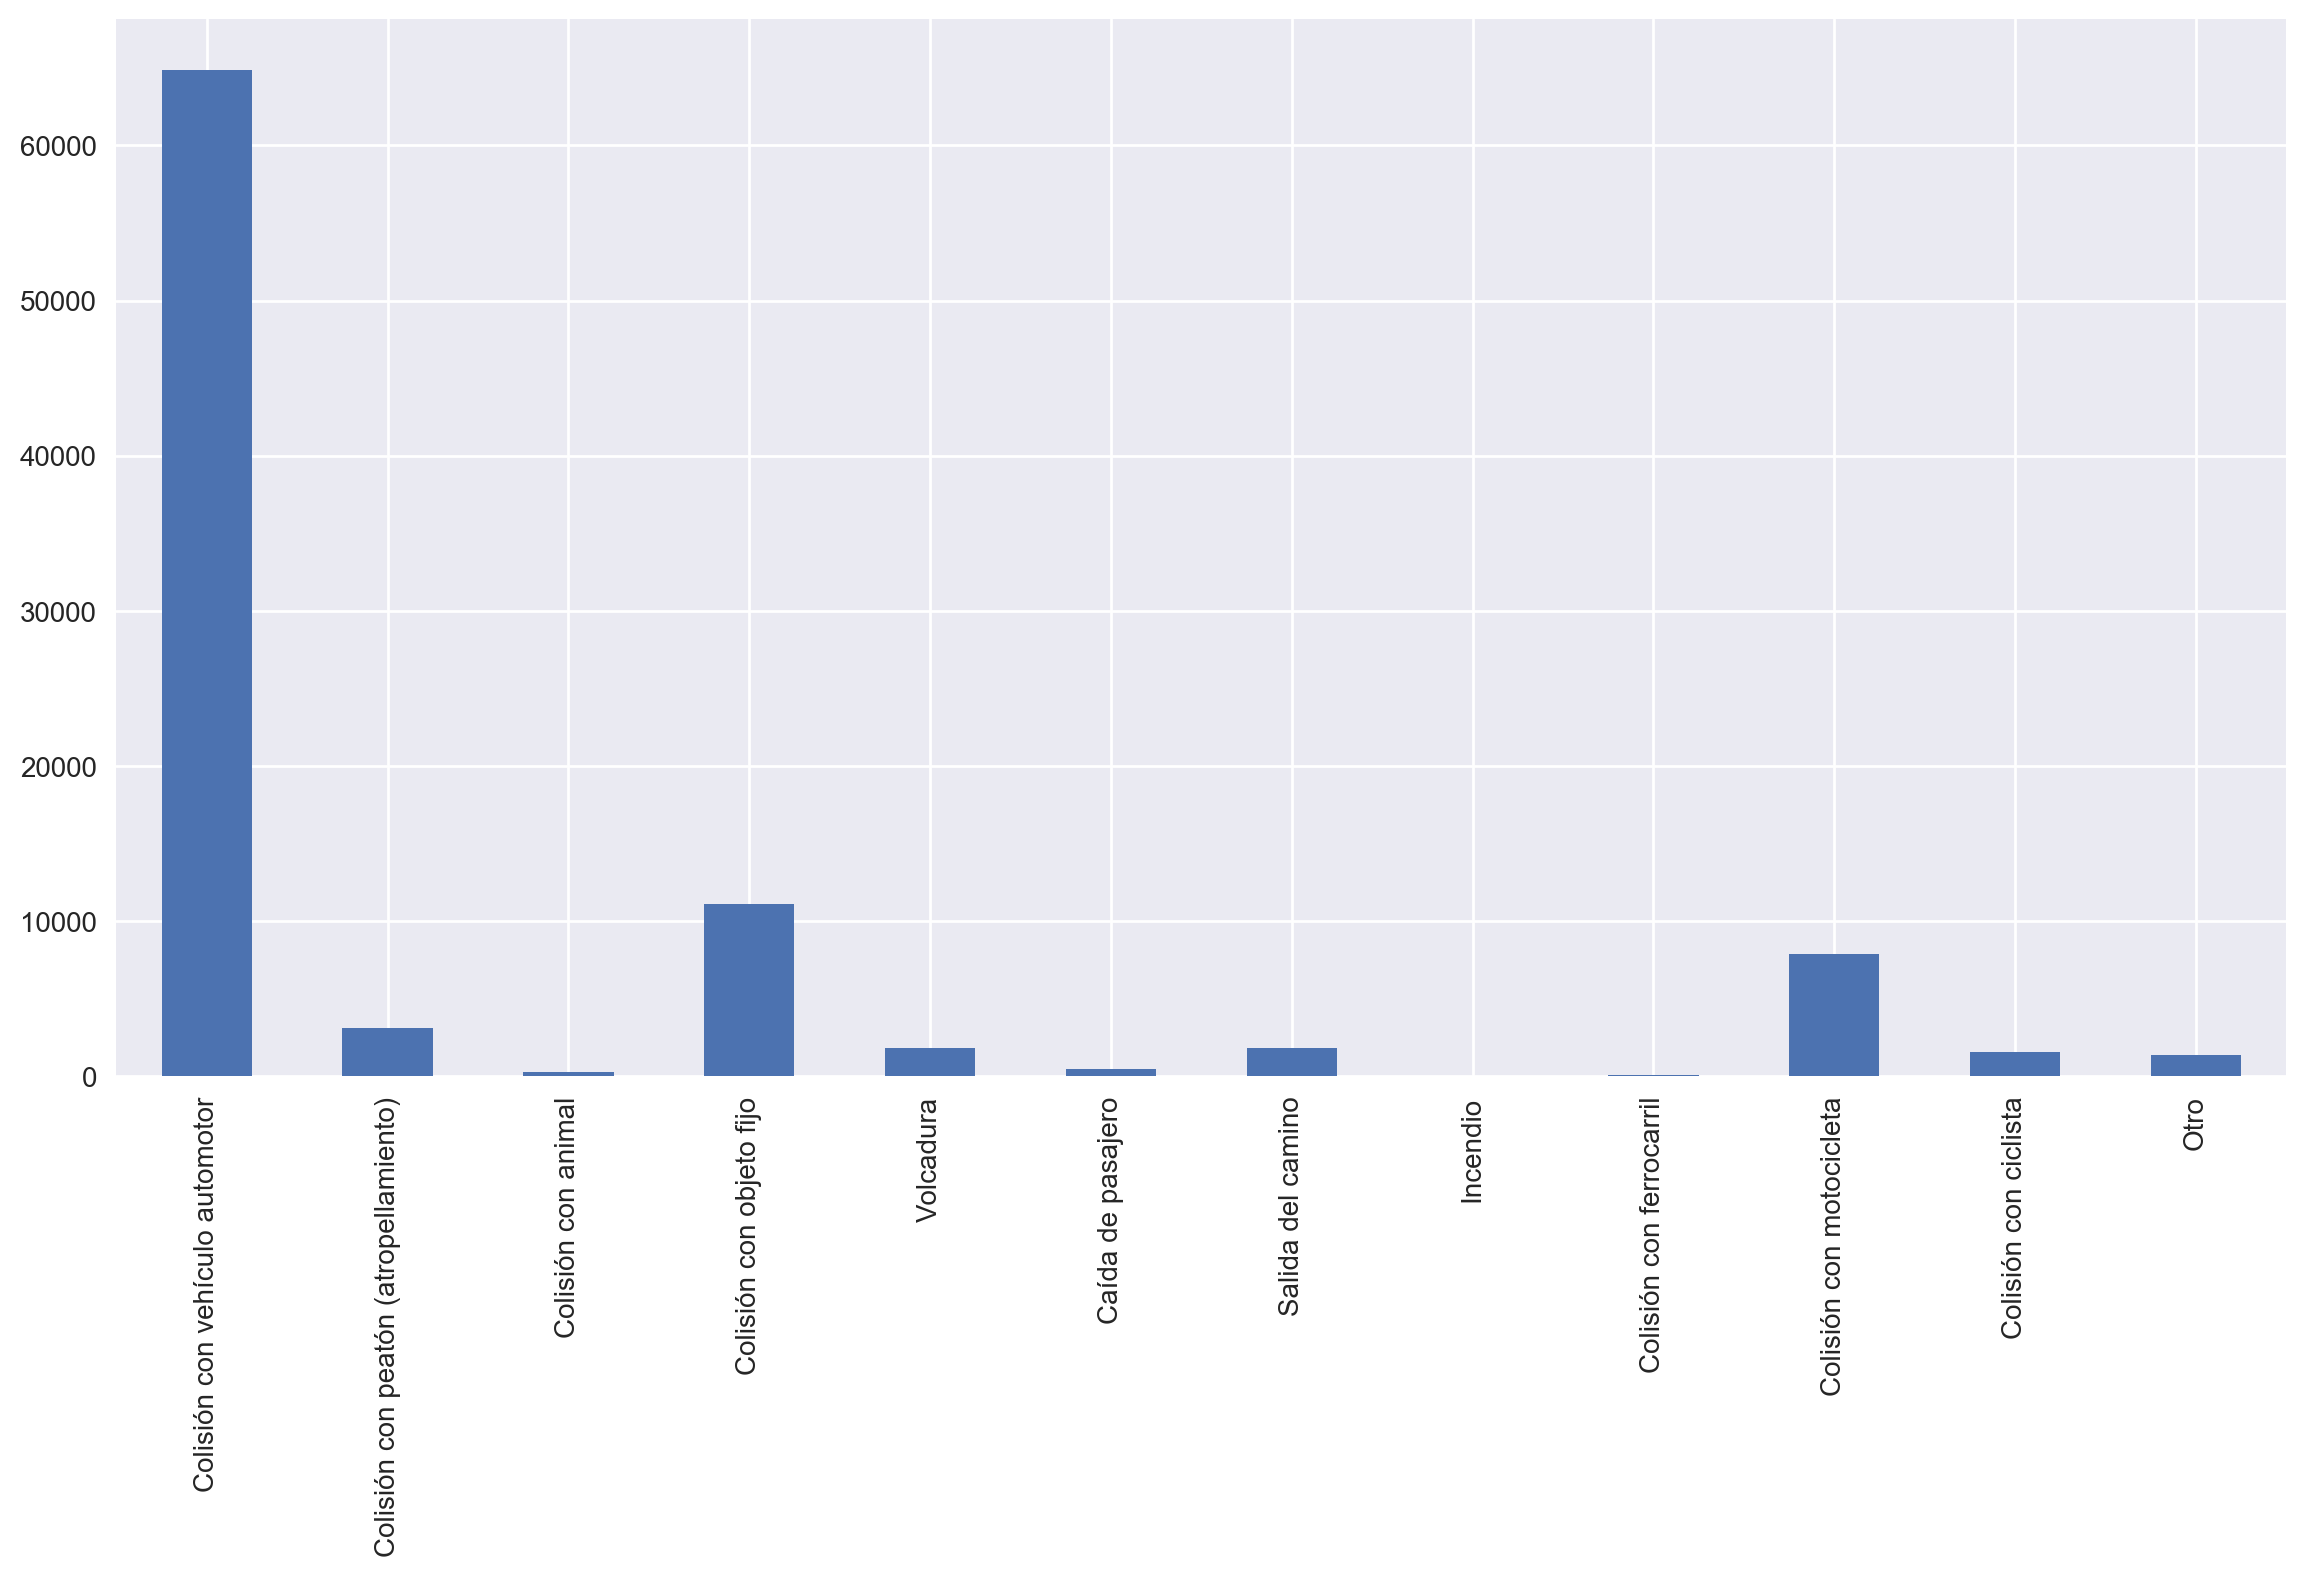

In [174]:
plt.figure(figsize=(14,7), dpi=200)
accidents_type = acc_train.TIPACCID.value_counts(sort=False)
accidents_type.plot(kind="bar")
plt.xticks(range(12), acc_code, rotation=90);

-------
# Fitting the Model

Pipeline for the data. It will choose the desired variables (categorical and discrete). With the catgorical variables, it will split them in order to get a One Hot Encoder

In [116]:
# Choosing the Xs and Y
acc_labels = acc_train["SEXO"]
acc_values = acc_train.drop("SEXO", axis=1)

In [117]:
categorical = ["EDO", "MES", "DIASEMANA", "ALIENTO", "CINTURON"]
categorical = ["MES", "DIASEMANA", "ALIENTO", "CINTURON"]
discrete = ["EDAD", "MES", "HORA"]

cat_pipeline = Pipeline([
    ("selector", DFSelector(categorical)),
    ("hot_encoder", OneHotEncoder(sparse=False))
])

disc_pipeline = Pipeline([
    ("selector", DFSelector(discrete))
]) 

accidents_pipeline = FeatureUnion(transformer_list=[
    ("discrete", disc_pipeline),
    ("categorical", cat_pipeline)
])

In [118]:
acc_values = accidents_pipeline.fit_transform(acc_values)
acc_values.shape

(94469, 26)

In [119]:
pd.DataFrame(acc_values).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,32.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,24.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,86.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,31.0,9.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,23.0,2.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## Fitting a Logistic Regression

We import the logistic regressio and the accuracy score to make a first test of the data. 

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [127]:
lreg = LogisticRegression()
lreg.fit(acc_values, acc_labels)

In [125]:
accuracy_score(acc_labels, lreg.predict(acc_values))

0.83012416771639375

### Cross Validating

In [136]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lreg, acc_values, acc_labels)

In [137]:
scores

array([ 0.83011019,  0.83013116,  0.83013116])